# 158.739 Introduction to Analytics Assignment 4
### by Qianying Wu (Momo) 18041217

# Introduction
This report mainly describes the data analysis of electricity generation and consumption in New Zealand. It analyzes electricity production data provided by WorldBank and electricity generation and residential electricity consumption data provided by MBIE(Ministry of Business Innovation & Employment) and some related supported data provided by Website KNOEMA.

These datasets are very scattered and trivial. Therefore, the analyzing processes below include data collection, data reorganization, exploratory data analysis, and data presentation.

## Goals
I tried to get some ideas by investigating and discussing the following: 

**The changes in the sources of electricity generation in New Zealand over the years and the reasons behind the changes and the features that they might present. Also, look at the residential electricity consumption by different council regions in New Zealand**

These goals are basically achieved and explained from the limited time-series data.

## Background
The Electricity sources available in New Zealand are separated into renewable and non-renewable sources. Renewable energy includes hydroelectric power, wind, solar, biogas, waste heat, and geothermal. In this report, the data on hydroelectric power generation is separated from the data on other renewable energy power generation. Non-renewable energy includes coal, natural gas, and oil.

# Data Acquisition
## Import of Python Packages

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import datetime
import matplotlib
import seaborn as sns

## Data of electricity production from sources
The data is mainly obtained from WorldBank through Web APIs, but the data is not sufficient. Therefore, after data comparison, the missing data from 2016 to 2019 are supplemented from MBIE's CSV file.

In [2]:
#======================================Web APIs from Worldbank to get electricity generation data=============================================
indicators = ['EG.ELC.COAL.ZS','EG.ELC.NGAS.ZS','EG.ELC.PETR.ZS','EG.ELC.HYRO.ZS','EG.ELC.RNWX.ZS']
df=pd.DataFrame()
for indicator in indicators:
    url="http://api.worldbank.org/v2/countries/all/indicators/%s?format=json&per_page=20000" % indicator
    response=requests.get(url)
    result=json.loads(response.content)
    temp_df=pd.DataFrame.from_dict(result[1])
    temp_df['country']=temp_df[['country']].applymap(lambda x:x['value'])
    temp_df=temp_df[['country','date','value']]
    temp_df=temp_df.loc[temp_df['country']=='New Zealand'].dropna()
    df=pd.concat([df,temp_df[['date','value']]],axis=1)
nz_electricity=df.copy()
nz_electricity.columns=['year','ele_production_coal_%oftotal','date','ele_production_naturalgas_%oftotal','date','ele_production_oil_%oftotal',
                        'date','ele_production_hydro_%oftotal','date','ele_production_renew_%oftotal']
nz_electricity=nz_electricity.drop(['date'],axis=1)
nz_electricity['year']=pd.to_datetime(nz_electricity['year']).dt.year
nz_electricity=nz_electricity.set_index('year')

The gov_table below provides the supplementary data to the nz_electricity table and the total net generation values in the exploratory data analysis part.

In [3]:
#=====================================================Import gov_table from MBIE==============================================================
df=pd.read_excel('../datasets/Electricity.xlsx',sheet_name='Table 2',skiprows=8,nrows=12).dropna()
df=df.transpose()
df=df.rename(columns=df.iloc[0])
gov_table=df.iloc[1:]
gov_table.columns=['Net_Generation(GWh)','Hydro','Geothermal','Biogas','Wood','Wind','Solar','Oil','Coal','Gas','Waste Heat']
gov_table=gov_table.drop('Annual % change').astype('float')
gov_table=gov_table.drop('2020P')

#=====================================Change the production values to be the percentage of total generation===================================
formatted_gov_generation=pd.DataFrame()
formatted_gov_generation['ele_production_coal_%oftotal']=gov_table['Coal']/gov_table['Net_Generation(GWh)']*100
formatted_gov_generation['ele_production_naturalgas_%oftotal']=gov_table['Gas']/gov_table['Net_Generation(GWh)']*100
formatted_gov_generation['ele_production_oil_%oftotal']=gov_table['Oil']/gov_table['Net_Generation(GWh)']*100
formatted_gov_generation['ele_production_hydro_%oftotal']=gov_table['Hydro']/gov_table['Net_Generation(GWh)']*100
formatted_gov_generation['ele_production_renew_%oftotal']=(gov_table['Geothermal']+gov_table['Biogas']+gov_table['Wind']+gov_table['Solar']+
                                                           gov_table['Waste Heat'])/gov_table['Net_Generation(GWh)']*100
formatted_gov_generation=formatted_gov_generation.sort_index(ascending=False)
#==========================================Compare the values from 1974 to 2015 in two table==================================================
for i in range(0,5):
    diff=nz_electricity[nz_electricity.columns[i]]-formatted_gov_generation[formatted_gov_generation.columns[i]]
    print('mean of differece:',diff.dropna().mean(),', standard deviation of difference:',diff.dropna().std())

mean of differece: 0.09456556320783478 , standard deviation of difference: 0.3139502050602627
mean of differece: 0.6555817141460146 , standard deviation of difference: 0.8478045247310244
mean of differece: 0.01107592186535276 , standard deviation of difference: 0.15269575814346584
mean of differece: -0.7040911443216122 , standard deviation of difference: 1.1651783570407885
mean of differece: 0.8672392575238409 , standard deviation of difference: 0.23920759566598926


From the comparison results above, the differences between the two tables are minimal. Therefore, I decided to fill the data from 2016 to 2019 to the nz_electricity table. 

In [4]:
#=============================================Fill 2016-2019 data to nz_electricity table=====================================================
fill_table=formatted_gov_generation.loc[[2016,2017,2018,2019]]
nz_electricity=nz_electricity.append(fill_table,sort=True).sort_index()
nz_electricity.head()

,ele_production_coal_%oftotal,ele_production_hydro_%oftotal,ele_production_naturalgas_%oftotal,ele_production_oil_%oftotal,ele_production_renew_%oftotal
1960,14.416738,79.750645,0.0,0.0,5.832617
1961,13.708399,79.371368,0.0,0.0,6.920232
1962,5.536375,84.438964,0.0,0.0,10.024661
1963,12.640787,75.658830,0.0,0.0,11.700383
1964,8.107835,79.038772,0.0,0.0,12.853393


## Data of electricity consumption
There are two tables performed in this stage. One table combines the residential electricity consumption by region(data provided by MBIE) with the population in council regions in New Zealand(data scraped from Wikipedia). The other one provides the NZ total consumption values(data provided by MBIE).

In [5]:
#===============================================Import residential consumption table==========================================================
df=pd.read_csv('../datasets/Residential_consumption.csv',skiprows=10)
residential_consumption=df.pivot_table(values=['Est. total consumption (GWh)','Average consumption (kWh)'],index=['Region description'],aggfunc='mean')

#===================================================Import total consumption tale=============================================================
df1=pd.read_excel('../datasets/Electricity.xlsx',sheet_name='Table 2',skiprows=40,nrows=1)
Total_Consumption=df1.transpose().dropna()
Total_Consumption.columns=['TotalConsumption(GWh)']
Total_Consumption=Total_Consumption.iloc[1:47]
index=range(1974,2020)
Total_Consumption.index=index

#===========================================Web scraping from Wiki to get population data=====================================================
url = "https://en.wikipedia.org/wiki/Regions_of_New_Zealand"
response = requests.get(url)
scraping_html_table = BeautifulSoup(response.content, "lxml") 
scraping_html_table = scraping_html_table.find_all("table", "wikitable")
df2 = pd.read_html(str(scraping_html_table))
first_table_df = df2[0]
first_table_df.columns = first_table_df.iloc[0]
first_table_df = first_table_df.iloc[2:]
population_df=first_table_df[['Region name(name in Māori if different)','Population[22]']]
population_df.columns=['Region description','Population']
population_df['Region description'].replace({"Auckland(1)Tāmaki-makau-rau": "Auckland", "Bay of PlentyTe Moana-a-Toi": "Bay of Plenty",
                                            "Gisborne(1)(2)Te Tai Rāwhiti":"Gisborne","Hawke's BayTe Matau-a-Māui":"Hawke's Bay",
                                            "WellingtonTe Whanga-nui-a-Tara":"Wellington","Tasman(1)Te Tai-o-Aorere":"Tasman",
                                            "Nelson(1)Whakatū":"Nelson","Marlborough(1)Te Tauihu-o-te-waka":"Marlborough",
                                            "West CoastTe Tai Poutini":"West Coast","CanterburyWaitaha":"Canterbury",
                                            "OtagoŌtākou":"Otago","SouthlandMurihiku":"Southland"}, inplace=True)
population_df=population_df.set_index('Region description')

#==============================================Merge residential consumption and population===================================================
residential_table=pd.merge(residential_consumption,population_df,left_index=True, right_index=True,how='inner').astype('float')
residential_table.head()

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Average consumption (kWh),Est. total consumption (GWh),Population
Region description,,,
Auckland,7171.9,3666.3934,1717500.0
Bay of Plenty,6684.9,790.6301,337300.0
Canterbury,8597.8,2048.1624,645900.0
Gisborne,6432.4,99.4037,50700.0
Hawke's Bay,7239.9,471.6363,178600.0


## Related supported data
I collected supporting data through Web scraping to explain some characteristics or appearances of electricity generation from different sources. Data include New Zealand Coal Production, Natural Gas Production, Annual Rain fall index, Geothermal Production, and Wind Production.

In [6]:
#========================================================Create a web scraping function=======================================================
def web_scraping(url):
    response=requests.get(url)
    page=response.content
    scraping=BeautifulSoup(page,"lxml")
    table=scraping.find_all('table',attrs={'class':'knoema-table'})
    df=pd.read_html(str(table))
    return df[0].set_index('Date')

#=================================================================Create tables===============================================================
coal_production=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Energy/Coal/Primary-coal-production")
naturalgas_production=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Energy/Gas/Natural-gas-production")
rainfall=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Water/Precipitation/National-rainfall-index")
geothermal_production=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Energy/Electricity/Geothermal-electricity-net-generation")
wind_production=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Energy/Electricity/Wind-electricity-net-generation")

In [7]:
print('first line of coal production table:',coal_production.head(1))
print('first line of naturalgas production table:',naturalgas_production.head(1))
print('first line of rainfall index table:',rainfall.head(1))
print('first line of geothermal production table:',geothermal_production.head(1))
print('first line of wind production table:',wind_production.head(1))

first line of coal production table:       Value Change, %
Date                 
2019   3344   -6.09 %
first line of naturalgas production table:        Value Change, %
Date                  
2015  181.45   -3.35 %
first line of rainfall index table:       Value Change, %
Date                 
2017   1154    0.00 %
first line of geothermal production table:       Value Change, %
Date                 
2019   7.44   -0.99 %
first line of wind production table:       Value Change, %
Date                 
2019   2.22    8.55 %


# Data Wrangling
In this stage, mainly check two converted and merged tables.

**Step1 - Handle Duplicates:** Check and remove duplicates to prevent multiple occurrences of data in the same year.

**Step2 - Check Data Type:** Confirm the values in tables are float.

**Step3 - Handle Missing Values:** Check abd fix missing values in tables.

In [8]:
check_list=[nz_electricity,residential_table]
for table in check_list:
    #===========================Check duplicates=============================
    for i in range(len(table.index)):
        if nz_electricity.index.duplicated()[i]== True:
            print("Need to remove duplicates.")
        else:
            pass    
    #==========================Check data types===============================
    for c in table.columns:
        if table[c].dtypes != 'float64':
            print('Need to cahnge types.')
        else:
            pass
    #========================Check missing values=============================
    if table.isnull().values.any() == True:
        print('Need to fix missing values')
    else:
        pass

There are no duplicate data and no missing values in tables; the data type is float.

# Exploratory Data Analysis

### Target table: nz_electricity table
In this part, I will focus on analyzing the electricity generation rate from each source over the years and finding out the stories behind the data. Also, I will look at the characteristic of electricity generation and consumption. This exploratory data analysis is mainly divided into the following subsections:

- Electricity statistics overview.
- Electricity production from coal and coal production in New Zealand.
- Electricity production from natural gas and natural gas production in New Zealand.
- Electricity production from oil and oil production in New Zealand.
- Electricity production from hydroelectric power and annual rainfall index in New Zealand.
- Electricity production from renewable sources except hydroelectric; geothermal and wind production in New Zealand.
- Electricity consumption by region and population in regions.

**Assumptions:**
- New Zealand’s power generation and consumption are increasing year by year.
- Hydroelectricity and other renewable energy production are also increasing.
- Due to environmental protection reasons, the power generation of non-renewable energy is declining.


## Electricity Statistics Overview

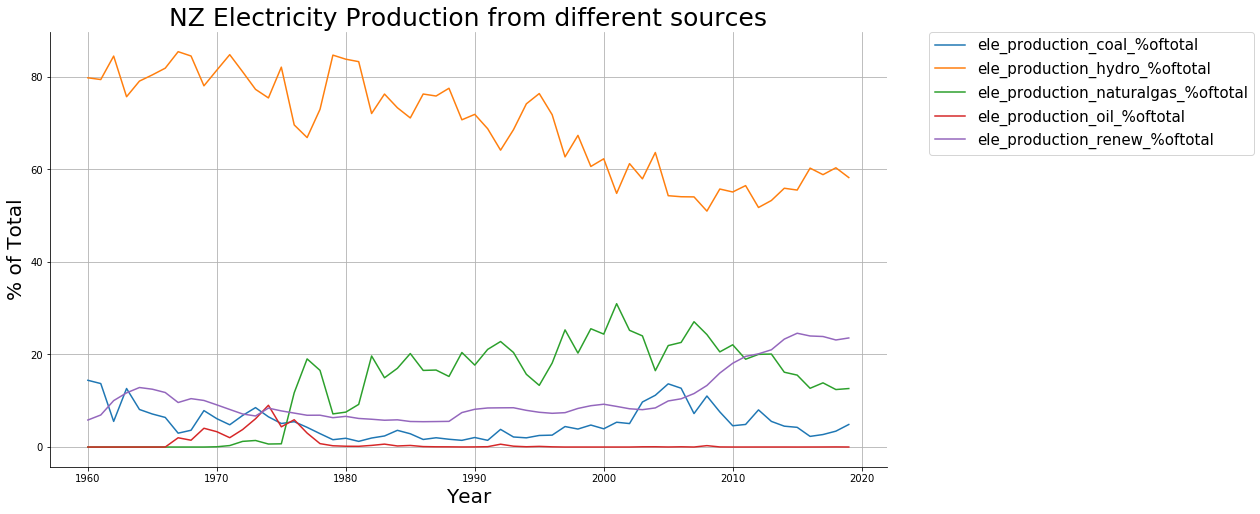

In [9]:
nz_electricity.plot(figsize=(15,8))
plt.title('NZ Electricity Production from different sources',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('% of Total',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=15)

Hydroelectric power generation accounts for the majority of New Zealand’s total power generation, ranging from 60% to 80%. In 2007, the renewable power generation curve and the coal power generation curve crossed over. Since then, the gap in these two power generation has widened. Similarly, the renewable power generation curve also crossed the natural gas power generation curve in 2011.In general, New Zealand’s power generation methods are environmentally friendly.

At the same time, it is worth noting that New Zealand's high dependence on hydroelectric power generation may bring potential risks due to the impact of extreme weather.

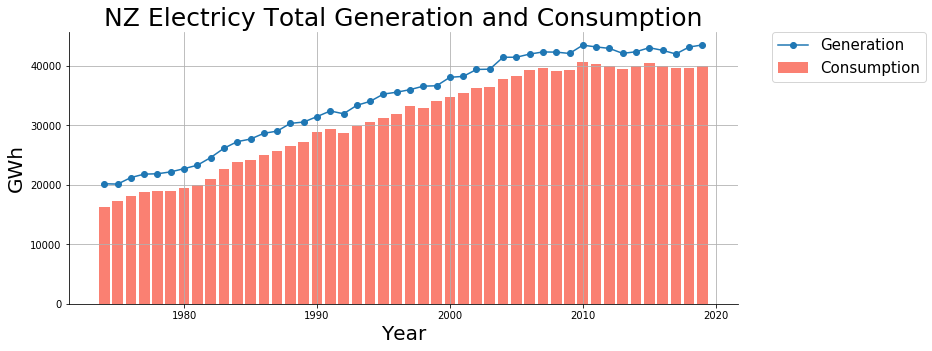

In [10]:
plt.figure(figsize=(12,5))
plt.plot(gov_table.index,gov_table['Net_Generation(GWh)'],'-o')
plt.bar(Total_Consumption.index,Total_Consumption['TotalConsumption(GWh)'],color='salmon')
plt.title('NZ Electricy Total Generation and Consumption',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('GWh',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')
ax.legend(labels=['Generation','Consumption'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=15)

As can be seen from the above figure, total power generation and consumption increase year by year, which is related to New Zealand’s population growth, economic development, and industrial upgrading. The difference between total power generation and total energy consumption in New Zealand has remained within a fixed range. This means that New Zealand’s total power generation has been effectively monitored and controlled. The risk of a nationwide power shortage or a nationwide blackout in New Zealand is shallow.

## Electricity production from coal

Outliers are
1960    14.416738
1961    13.708399
2005    13.649693
Name: ele_production_coal_%oftotal, dtype: float64
The outliers within a reasonable range and do not need to be processed.


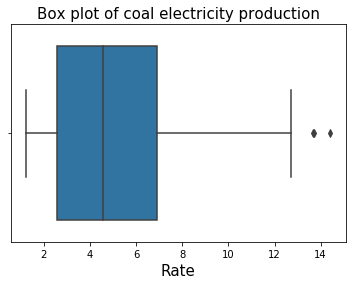

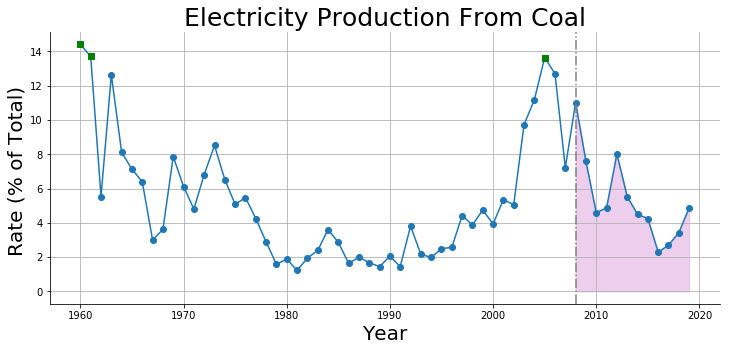

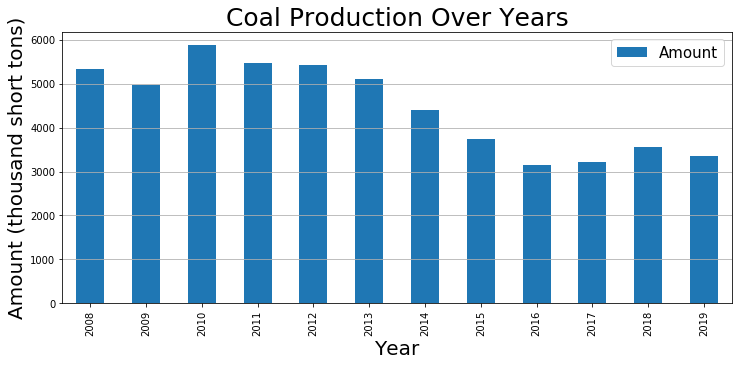

In [11]:
#=============================================================Find out outliers===============================================================
sns.boxplot(x=nz_electricity['ele_production_coal_%oftotal'])
plt.title('Box plot of coal electricity production',fontsize=15)
plt.xlabel('Rate',fontsize=15)
print('Outliers are')
print(nz_electricity['ele_production_coal_%oftotal'].loc[nz_electricity['ele_production_coal_%oftotal']>(2.5*nz_electricity['ele_production_coal_%oftotal'].quantile(0.75)-1.5*nz_electricity['ele_production_coal_%oftotal'].quantile(0.25))])
print('The outliers within a reasonable range and do not need to be processed.')

#========================================================Plot coal electricity production curve===============================================
plt.figure(figsize=(12,5))
plt.plot(nz_electricity.index,nz_electricity['ele_production_coal_%oftotal'],'-o')
plt.title('Electricity Production From Coal',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Rate (% of Total) ',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')

#==========================================================Point out outliers on the curve====================================================
plt.plot(1960, nz_electricity['ele_production_coal_%oftotal'].loc[1960], "s",color='green')
plt.plot(1961, nz_electricity['ele_production_coal_%oftotal'].loc[1961], "s",color='green')
plt.plot(2005, nz_electricity['ele_production_coal_%oftotal'].loc[2005], "s",color='green')

#==========================================Range out the selected years in coal production on the curve=======================================
plt.axvline(x=2008,color='grey',linestyle="-.")
plt.fill_between(range(2008,2020),0,nz_electricity['ele_production_coal_%oftotal'].loc[2008:2019],alpha=0.5,color='plum')

#========================================================Plot coal production in New Zealand==================================================
coal_production.sort_index(axis = 0).plot.bar(figsize=(12,5))
ax = plt.gca()
ax.grid(axis='y')
plt.title('Coal Production Over Years',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Amount (thousand short tons)',fontsize=20)
ax.legend(labels=['Amount'],fontsize=15)

Take a look at the coal power generation curve. Overall, coal power generation accounts for less than 14.5 percent of New Zealand’s total power generation. Compared with the total power generation energy curve mentioned above, in the early 1960s, coal power generation ranked second in energy power generation. From 1960 to 1990, although coal power generation fluctuated, it declined in general. From 1990 to 2005, coal power generation continued to rise, and coal power generation peaked in 2005. Then it started to decrease again.

During the 20th century, New Zealand’s economic growth mainly relied on the extraction of limited resources such as gold and oil, including coal. This may be why coal was the second or third largest electricity generation in New Zealand in the 1960s. Starting in 1990, New Zealand's economy began to develop. Especially after entering the 21st century, New Zealand has implemented economic transformation; along with New Zealand's loose immigration policy, a large influx of labor has increased New Zealand's population. As a result, the demand for electricity in New Zealand had increased. However, during this period, hydropower generation decreased, and renewable energy generation did not be able to fill the gap. Therefore, coal power generation increased. After 2005, New Zealand implemented active sustainable development policies and environmental protection policies; simultaneously, new energy power generation increased; coal power generation decreased accordingly. (Reference NZ Economic history and the Politicization of Immigration)

Although there is a lack of sufficient data, we can also see that the trend of coal power generation seems to lag behind coal production for two years.

## Electricity production from natural gas

No outliers


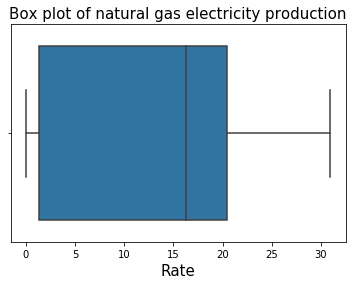

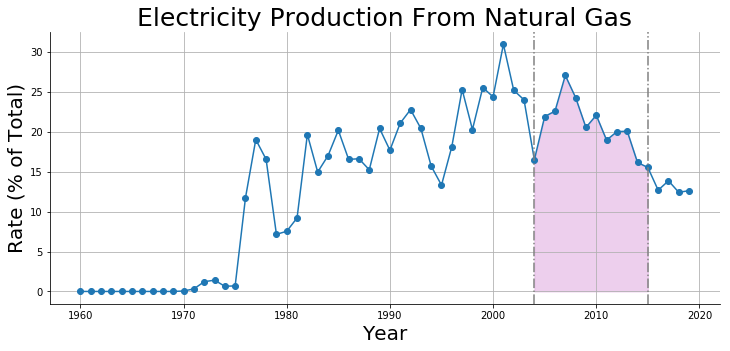

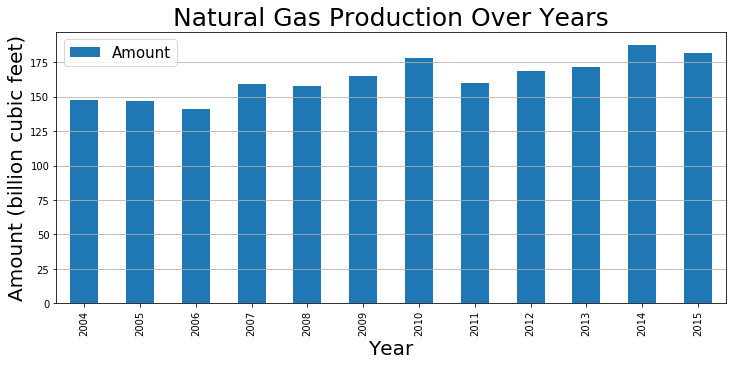

In [12]:
#=============================================================Find out outliers===============================================================
sns.boxplot(x=nz_electricity['ele_production_naturalgas_%oftotal'])
plt.title('Box plot of natural gas electricity production',fontsize=15)
plt.xlabel('Rate',fontsize=15)
print('No outliers')

#========================================================Plot natural gas electricity production curve========================================
plt.figure(figsize=(12,5))
plt.plot(nz_electricity.index,nz_electricity['ele_production_naturalgas_%oftotal'],'-o')
plt.title('Electricity Production From Natural Gas',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Rate (% of Total)',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')

#==========================================Range out the selected years in natural gas production on the curve================================
plt.axvline(x=2004,color='grey',linestyle="-.")
plt.axvline(x=2015,color='grey',linestyle="-.")
plt.fill_between(range(2004,2016),0,nz_electricity['ele_production_naturalgas_%oftotal'].loc[2004:2015],alpha=0.5,color='plum')

#======================================================Plot natural gas production in New Zealand=============================================
naturalgas_production.sort_index(axis = 0).plot.bar(figsize=(12,5))
ax = plt.gca()
ax.grid(axis='y')
plt.title('Natural Gas Production Over Years',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Amount (billion cubic feet)',fontsize=20)
ax.legend(labels=['Amount'],fontsize=15)

The natural gas electricity generation curve shows that since 1975, natural gas power generation had surged. This growth trend continued until 2001, peaked in 2001, and then declined. The declining trend of natural gas power generation in modern times is more stable than coal power generation. Relating to the above total power generation curve, from 1976 to 2010, natural gas power generation had always been the second place in New Zealand's total power generation. Moreover, the power generation was about 20%, and the peak was 30%. Until 2011, it was surpassed by new energy generation.

New Zealand's gas fields only started production and operation in 1970. Therefore, there was no natural gas power generation in New Zealand before. Natural gas has been described as a "transition fuel" to reduce the use of coal. Therefore, since the exploitation of natural gas, the proportion of electricity generated by coal has decreased. The curve reflected this characteristic very accurately in 2004. Natural gas power generation suddenly trough in 2004, when coal power generation reached its peak. The low power generation in 2004 was due to the closure of the two Motunui methanol trains during the year. (Reference the state and performance of the New Zealand gas industry)

Unfortunately, due to the lack of data, I cannot find the relationship between natural gas production and natural gas power generation.

## Electricity production from Oil

Outliers are
1967    2.001187
1968    1.468927
1969    4.055488
1970    3.311164
1971    2.015764
1972    3.775620
1973    6.108683
1974    9.018483
1975    4.366855
1976    5.895787
1977    3.014063
Name: ele_production_oil_%oftotal, dtype: float64
The outliers within a reasonable range and do not need to be processed.


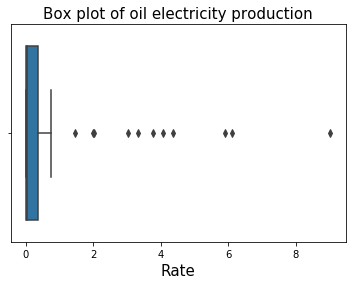

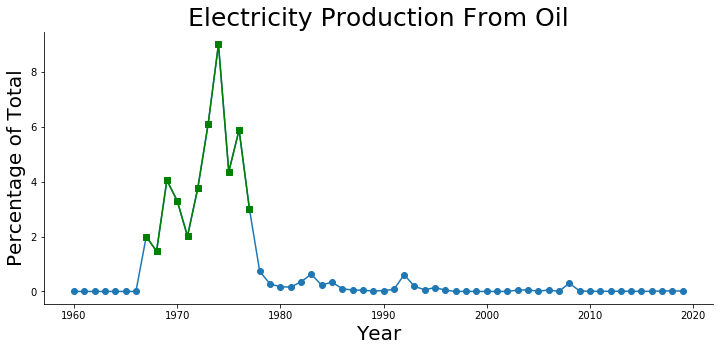

In [13]:
#=============================================================Find out outliers===============================================================
sns.boxplot(x=nz_electricity['ele_production_oil_%oftotal'])
plt.title('Box plot of oil electricity production',fontsize=15)
plt.xlabel('Rate',fontsize=15)
print('Outliers are')
print(nz_electricity['ele_production_oil_%oftotal'].loc[nz_electricity['ele_production_oil_%oftotal']>(2.5*nz_electricity['ele_production_oil_%oftotal'].quantile(0.75)-1.5*nz_electricity['ele_production_oil_%oftotal'].quantile(0.25))])
print('The outliers within a reasonable range and do not need to be processed.')

#========================================================Plot oil electricity production curve================================================
plt.figure(figsize=(12,5))
plt.plot(nz_electricity.index,nz_electricity['ele_production_oil_%oftotal'],'-o')
plt.title('Electricity Production From Oil',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Percentage of Total',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')

#==========================================================Point out outliers on the curve====================================================
nz_electricity['ele_production_oil_%oftotal'].loc[1967:1977].plot(marker="s",color='green')

In general, New Zealand hardly used oil to generate electricity, except from 1967 to 1978. During this period, oil power generation also accounted for a tiny part of New Zealand's total power generation. 

In connection with the above-mentioned total power generation curve, with the development and use of natural gas, natural gas power generation had completely replaced oil power generation. New Zealand is a major producer of natural gas. Even though the McKee oil field was discovered in 1979, New Zealand no longer used oil to generate electricity.

## Electricity production from hydroelectric power

No outliers


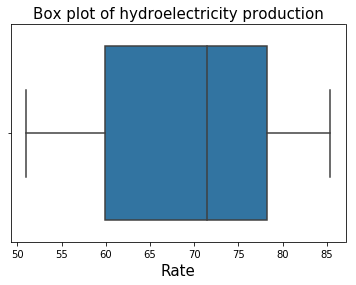

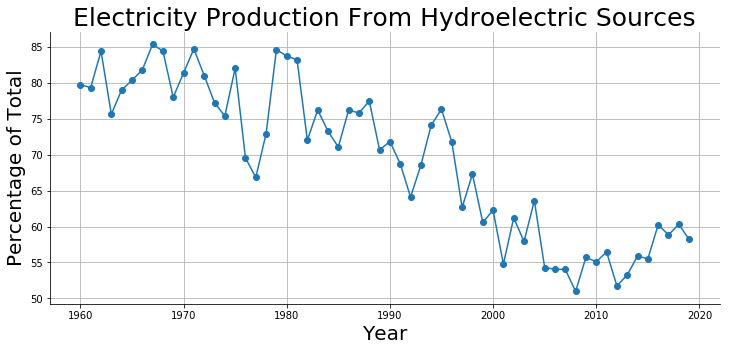

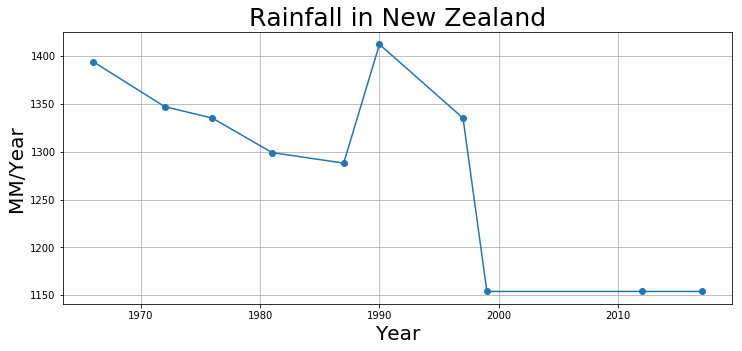

In [14]:
#=============================================================Find out outliers===============================================================
sns.boxplot(x=nz_electricity['ele_production_hydro_%oftotal'])
plt.title('Box plot of hydroelectricity production',fontsize=15)
plt.xlabel('Rate',fontsize=15)
print('No outliers')

#========================================================Plot hydroelectricity production curve===============================================
plt.figure(figsize=(12,5))
plt.plot(nz_electricity.index,nz_electricity['ele_production_hydro_%oftotal'],'-o')
plt.title('Electricity Production From Hydroelectric Sources',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Percentage of Total',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')

#=======================================================Plot annual rainfall index in New Zealand=============================================
plt.figure(figsize=(12,5))
plt.plot(rainfall.index,rainfall['Value'],'-o')
plt.title('Rainfall in New Zealand',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('MM/Year',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.grid(axis='y')
ax.grid(axis='x')

New Zealand’s hydropower has always accounted for the largest portion of New Zealand’s total power generation. In general, hydroelectric power generation has decreased year by year, from 85% of total power generation to 55%. Hydro power provided 85% of electrical energy in 1967, but by 2008 this had dropped to nearly 50%. The electricity generated by gas and coal increased substantially over this period. 

New Zealand is a country with abundant water resources. New Zealand has used hydropower for more than 100 years. However, New Zealand's water storage is relatively small, and the annual water supply varies greatly. Therefore, the amount of hydroelectric power generation is easily affected by climate and rainfall.

The rainfall curve in the figure above confirms this statement. On the whole, rainfall has dropped significantly. The rainfall has been declining cliff-like since 1990. Although limited by the amount of data and the length of the research, this conclusion still needs to be further refined or corrected.

## Electricity production from renewable sources

Outliers are
2011    19.576018
2012    20.129225
2013    21.006286
2014    23.307666
2015    24.578668
2016    23.986710
2017    23.873114
2018    23.122380
2019    23.559283
Name: ele_production_renew_%oftotal, dtype: float64
The outliers within a reasonable range and do not need to be processed.


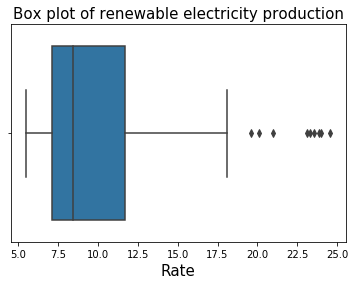

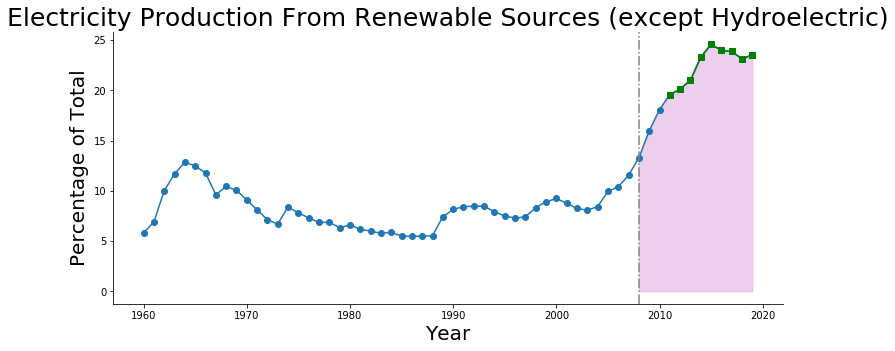

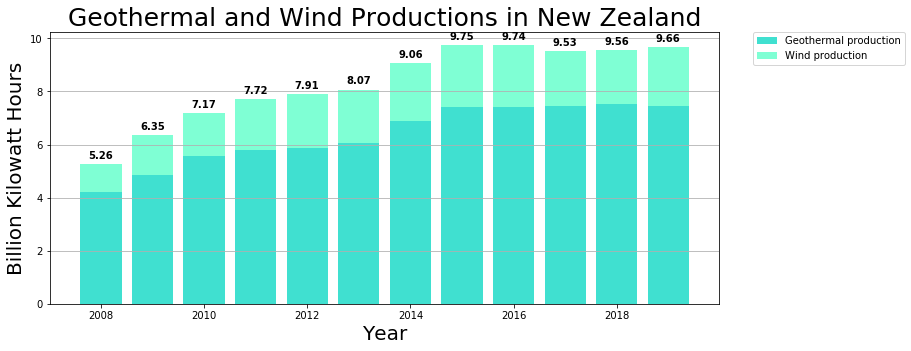

In [22]:
#=============================================================Find out outliers===============================================================
sns.boxplot(x=nz_electricity['ele_production_renew_%oftotal'])
plt.title('Box plot of renewable electricity production',fontsize=15)
plt.xlabel('Rate',fontsize=15)
print('Outliers are')
print(nz_electricity['ele_production_renew_%oftotal'].loc[nz_electricity['ele_production_renew_%oftotal']>(2.5*nz_electricity['ele_production_renew_%oftotal'].quantile(0.75)-1.5*nz_electricity['ele_production_renew_%oftotal'].quantile(0.25))])
print('The outliers within a reasonable range and do not need to be processed.')

#=====================================================Plot renewable electricity production curve=============================================
plt.figure(figsize=(12,5))
plt.plot(nz_electricity.index,nz_electricity['ele_production_renew_%oftotal'],'-o')
plt.title('Electricity Production From Renewable Sources (except Hydroelectric)',fontsize=25)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Percentage of Total',fontsize=20)
matplotlib.rc('axes.spines', top = True, right = True)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.grid(axis='x')

#==========================================================Point out outliers on the curve====================================================
nz_electricity['ele_production_renew_%oftotal'].loc[2011:].plot(marker="s",color='green')

#=====================================Range out the selected years in wind and geothermal production on the curve=============================
plt.axvline(x=2008,color='grey',linestyle="-.")
plt.fill_between(range(2008,2020),0,nz_electricity['ele_production_renew_%oftotal'].loc[2008:2019],alpha=0.5,color='plum')

#=================================================Plot wind and geothermal production in New Zealand==========================================
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.bar(geothermal_production.index,geothermal_production['Value'],color='turquoise')
ax.bar(wind_production.index,wind_production['Value'], bottom=geothermal_production['Value'],color='aquamarine')
ax.set_ylabel('Billion Kilowatt Hours',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_title('Geothermal and Wind Productions in New Zealand',fontsize=25)
totals = geothermal_production['Value']+wind_production['Value']
y_offset = 0.2
for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset,round(total,2), ha='center',weight='bold')
ax.legend(labels=['Geothermal production', 'Wind production'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.grid(axis='y')
plt.show()

From the curve of the proportion of renewable energy power generation, we can see that renewable energy power generation is on the rise in New Zealand. From 1960 to 2006, the proportion of renewable energy power generation was very stable. Since 2007, it has grown by leaps and bounds. From only 5% in 1960, it has grown to about 25% now. Combined with the above-mentioned proportion of hydroelectric power generation, the power generation of renewable energy accounts for more than 80% of New Zealand's total power generation.

It can also be seen from the production of geothermal and wind energy that renewable energy sources such as geothermal and wind energy have continued to increase. In ten years, the output of renewable energy has nearly tripled.

New Zealand’s new coalition government has committed to introducing zero-carbon legislation that would set the country on a course to be carbon neutral by 2050. Therefore, it can be inferred that the future source of power generation in New Zealand will come from renewable energy sources. The proportion of renewable energy power generation will only increase.

## Electricity Consumption by region

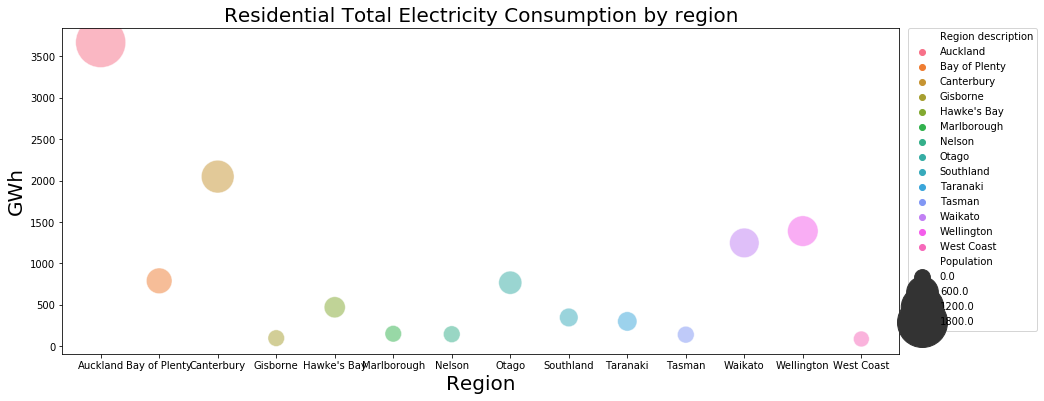

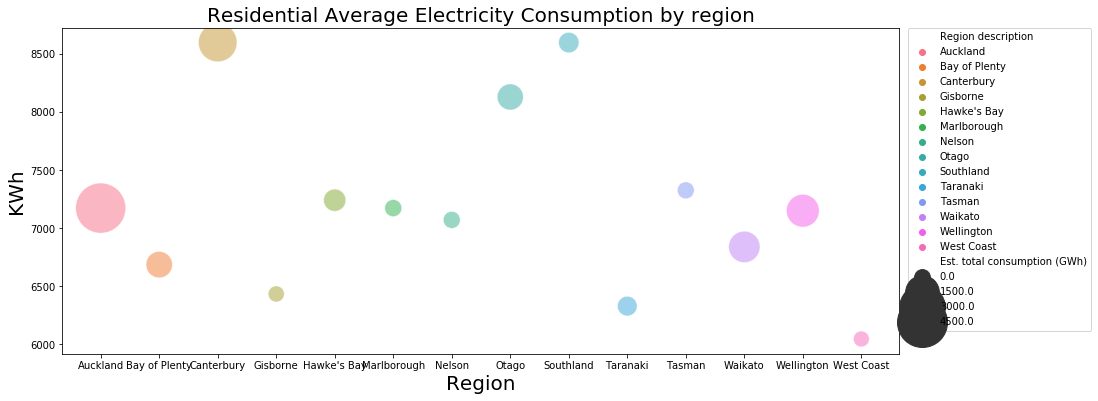

In [16]:
#================================================plot residential total consumption by region and population==================================
fig = plt.figure(figsize=(15,6))
colors = np.random.rand(len(residential_table.index))
sns.scatterplot(residential_table.index,residential_table['Est. total consumption (GWh)'],size=residential_table['Population']/1000,alpha=0.5,hue=residential_table.index,sizes=(250,2500))
plt.xlabel("Region", size=20)
plt.ylabel("GWh", size=20)
plt.title("Residential Total Electricity Consumption by region", size=20)
plt.legend(bbox_to_anchor=(1.01,1),borderaxespad=0)

#================================================plot residential total consumption by region and population==================================
fig = plt.figure(figsize=(15,6))
colors = np.random.rand(len(residential_table.index))
sns.scatterplot(residential_table.index,residential_table['Average consumption (kWh)'],size=residential_table['Est. total consumption (GWh)'],alpha=0.5,hue=residential_table.index,sizes=(250,2500))
plt.xlabel("Region", size=20)
plt.ylabel("KWh", size=20)
plt.title("Residential Average Electricity Consumption by region", size=20)
plt.legend(bbox_to_anchor=(1.01,1),borderaxespad=0)

From the above Residential Total Electricity Consumption figure, we can conclude that Auckland is the area with the most electricity consumption by residents, and of course, this is related to it has the largest population. Canterbury is the second largest area in New Zealand in terms of total electricity consumption by residents and the largest area in the South Island. Wellington and Waikato ranked third and fourth, respectively.

For technical reasons, I cannot display the data more intuitively on the map, but we can also draw some conclusions from the Residential Average Electricity Consumption figure. 

- Canterbury, South Island, and Otago are the top three regions with the highest average residential electricity consumption. These three regions all belong to the south-central and southern parts of New Zealand's South Island. Therefore, the average electricity consumption of residents in this situation may be related to the average temperature. People here are more dependent on electricity. 

- The west coast, also located in the middle of the South Island, has the lowest electricity consumption per capita. At present, I do not have enough data to explain this phenomenon, but I guess it may be related to ocean currents. 

- Auckland is located in the north-central part of New Zealand's North Island, but its per capita electricity consumption is similar to Hawke's Bay in the south-central North Island and Wellington in the south. I need more information to explain this.

# Conclusion
The goals I outlined in this report have basically been achieved. Most of the results confirmed my assumptions, except the rate of hydroelectricity production.

## Overall of the findings
* New Zealand's power generation and consumption are increasing year by year. Also, both power generation and electricity consumption are within a controllable and supervisable range. Unless a major natural disaster occurs, New Zealand's electricity supply is guaranteed.

* New Zealand's renewable energy generation continues to increase, while non-renewable energy generation is decreasing. Among them, the reform and construction of hydropower still need to work hard. New Zealand is expected to achieve the goal of 2050 carbon neutrality.

* The total electricity consumption of residents is the highest in the North Island of New Zealand, but the average electricity consumption of residents is the highest in the South Island of New Zealand. The total electricity consumption of residents is related to the local population. The average electricity consumption of residents is related to more factors.

## Further improvements
Due to time and technology, there is still much data that cannot be collected and analyzed. For the analysis of electricity generation, includes the productions of coal, natural gas, oil, wind, solar, waste heat, and geothermal energy over a longer period of time; rainfall and lake water storage level over a longer period of time. For the analysis of electricity consumption, includes mapping of New Zealand, historical temperature records across New Zealand, data on New Zealand's east and west coasts affected by ocean currents, data on living standards and consumption habits in various regions, etc.

# Reference
1. Brain Easton(n.d.). *Story: Economic history (Page 12. Economy in the early 2000s)* Retrieved from https://teara.govt.nz/en/economic-history/page-12

2. Richard Bedford(01/2003) *New Zealand: The Politicization of Immigration* Retrieved from https://www.migrationpolicy.org/article/new-zealand-politicization-immigration

3. Anonymous(12/2017). *The New Zealand Gas Story: The state and performance of the New Zealand gas industry (sixth edition)* Retrieved from https://www.gasindustry.co.nz/about-the-industry/nz-gas-story/document/5806

# Bonus
Assume my 'residential_consumption.csv' is big data. I splited a large file into smaller chunks, and used Dask DataFrame to process the out-of-core.

In [17]:
file_path=r'D:\Users\momo_\datasets\\'

In [18]:
chunksize=19
#i=0
f=['a','b','c']
for i in range(0,len(f)):
    for df in pd.read_csv(file_path+'Residential_consumption - Copy.csv',chunksize=chunksize):
        df.to_csv(file_path + 'residential_consumption_' + f[i] + '.csv',index=None)
    i += 1

In [19]:
import dask.dataframe as dd

In [20]:
%time ddf_csv=dd.read_csv(file_path + 'Residential_consumption - Copy.csv',parse_dates=['Period start','Period end'])
ddf_csv.head()

Wall time: 33 ms


,Period start,Period end,Region ID,Region description,Average consumption (kWh),Est. total consumption (GWh),Coverage %
0,2010-01-01,2010-12-31,1,Northland,6513,453.703,90.23
1,2011-01-01,2011-12-31,1,Northland,6578,460.760,90.44
2,2012-01-01,2012-12-31,1,Northland,6533,449.399,89.68
3,2013-01-01,2013-12-31,1,Northland,6301,439.300,90.72
4,2014-01-01,2014-12-31,1,Northland,6252,444.692,90.71


In [21]:
import sys
sys.getsizeof(ddf_csv)

56